# Deep Learning


Asisten  :
1. I Putu Adhitya Pratama Mangku Purnama  : 0831-9292-5747
2. Wiweko Dwitya Anindito : 0812-8359-8159



[QNA DISINI!!!](https://its.id/m/qna_forecast24)

<img src="https://i.imgflip.com/8sqhdn.jpg"/>

credits to:
1. Ega Fernanda Putra
2. Muhammad Raffi Priyadiantama  

In [33]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras import Sequential
from keras.layers import SimpleRNN, Dense
from keras_tuner import RandomSearch
from keras.layers import GRU, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import LSTM

import warnings
warnings.filterwarnings("ignore")

# 0. EDA & Pre-processing

**Air Pollution Forecasting**

This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

| Kolom      | Deskripsi                                  | Tipe Data | Unit                           |
|------------|--------------------------------------------|-----------|--------------------------------|
| pollution  | Tingkat polusi udara pada waktu tertentu    | Float     | PM2.5  |
| dew        | Titik embun                                | Integer   | Derajat Celsius (°C)           |
| temp       | Suhu udara                                 | Float     | Derajat Celsius (°C)           |
| press      | Tekanan udara                              | Float     | Hektopascal (hPa)              |
| wnd_dir    | Arah angin                                 | String    | -                              |
| wnd_spd    | Kecepatan angin                            | Float     | Meter per detik (m/s)          |
| snow       | Kumulatif jam salju                     | Integer   | jam               |
| rain       | Kumulatif jam hujan                     | Integer   | jam               |


[Sumber](https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate)

## 0.1 Cleaning

In [3]:
# Read data
df = pd.read_csv('Dataset\\LSTM-Multivariate_pollution.csv', parse_dates=['date'], index_col='date')
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
# Cek null
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dew        43800 non-null  int64  
 2   temp       43800 non-null  float64
 3   press      43800 non-null  float64
 4   wnd_dir    43800 non-null  object 
 5   wnd_spd    43800 non-null  float64
 6   snow       43800 non-null  int64  
 7   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [5]:
# Drop kolom non angka
df.drop(columns=['wnd_dir'], inplace=True)

## 0.2 EDA

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

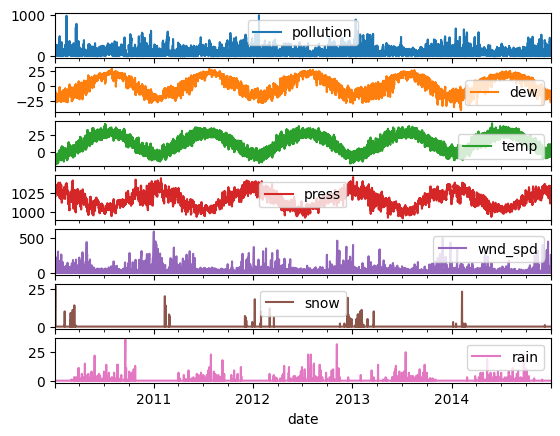

In [6]:
# Plot
df.plot(subplots=True)

<Axes: >

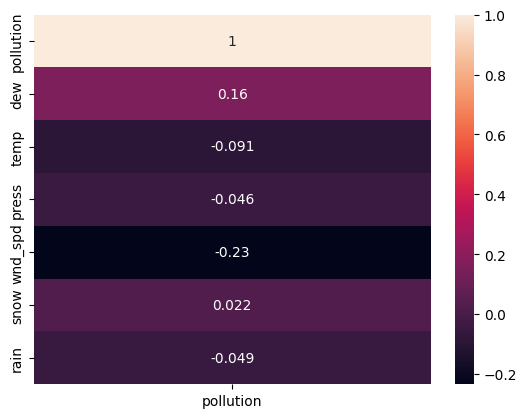

In [7]:
# Plot correlation
sns.heatmap(df.corr()[['pollution']], annot=True)

In [8]:
# Describe
df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


## 0.3 Pre-Processing

**Normalisasi**

Normalisasi digunakan untuk mencegah terjadinya bias akibat fitur pada model yang memiliki rentang nilai berbeda.

<br>


*   **MinMaxScaler**

MinMaxScaler akan menormalisasi nilai suatu fitu sehingga nilainya berada pada rentang 0 (minimum) - 1 (maximum).

$$
x' = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$

Terdapat juga jenis lain scaler seperti:


*   StandardScaler
*   RobustScaler
*   Normalizer
*   PowerTransformer

<br>

[Dokumentasi SKLearn](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)



In [9]:
# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

In [10]:
# Train-test split
train, test = train_test_split(scaled, test_size=0.1, shuffle=False, random_state=1337)

**Sliding Window**

<img src = 'https://miro.medium.com/v2/resize:fit:1400/format:webp/0*QErT8iJARIUK48EY.png'  />



```
Data:
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

Fitur (X):
[10, 20, 30]
[20, 30, 40]
[30, 40, 50]
[40, 50, 60]
[50, 60, 70]
[60, 70, 80]
[70, 80, 90]

Target (y):
[40]
[50]
[60]
[70]
[80]
[90]
[100]

```




In [11]:
# Sliding window
LENGTH = 24
BATCH_SIZE = 256

train_generator = TimeseriesGenerator(train, train[:,0], length=LENGTH, batch_size=BATCH_SIZE)
test_generator = TimeseriesGenerator(test, test[:,0], length=LENGTH, batch_size=1)

In [12]:
print(f'Untuk fitur dari id 0 - length: \n {train_generator[0][0][0]}\n')
print(f'Prediksi target (pollution) pada id length + 1: \n {train_generator[0][1][0]}')

Untuk fitur dari id 0 - length: 
 [[0.12977867 0.35294118 0.24590164 0.52727273 0.00229001 0.
  0.        ]
 [0.14889336 0.36764706 0.24590164 0.52727273 0.00381099 0.
  0.        ]
 [0.15995976 0.42647059 0.2295082  0.54545455 0.00533197 0.
  0.        ]
 [0.18209256 0.48529412 0.2295082  0.56363636 0.00839101 0.03703704
  0.        ]
 [0.138833   0.48529412 0.2295082  0.56363636 0.00991199 0.07407407
  0.        ]
 [0.10965795 0.48529412 0.21311475 0.56363636 0.01143297 0.11111111
  0.        ]
 [0.1056338  0.48529412 0.21311475 0.58181818 0.01449201 0.14814815
  0.        ]
 [0.12474849 0.48529412 0.2295082  0.6        0.01755106 0.
  0.        ]
 [0.12072435 0.47058824 0.21311475 0.6        0.0206101  0.
  0.        ]
 [0.13279678 0.48529412 0.2295082  0.61818182 0.02366914 0.
  0.        ]
 [0.14084507 0.48529412 0.2295082  0.63636364 0.0290182  0.03703704
  0.        ]
 [0.15291751 0.47058824 0.2295082  0.63636364 0.03436726 0.
  0.        ]
 [0.14889336 0.47058824 0.2295082  0.6

# 1. RNN

**Recurrent Neural Networks (RNN)**

RNN merupakan jenis ANN yang dapat memproses data dengan sequence / urutan.

<img src = 'https://www.oreilly.com/api/v2/epubs/9781787121089/files/assets/aff5748c-e921-4d49-b273-bae41683fa5a.png' style= "background-color: white;"/>

<img src = 'https://media.geeksforgeeks.org/wp-content/uploads/20231204125839/What-is-Recurrent-Neural-Network-660.webp' />

*   RNN memiliki hidden state / memory state yang menyimpan informasi dari sequence sebelumnya.
*   RNN menggunakan Backpropagation Through Time (BPTT) dan satu bobot untuk tiap lapisan untuk memperbarui W.
*   Pada RNN dapat terjadi permasalahan exploding / vanishing gradient.

[Referensi ](https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/)

[Video penjelasan](https://www.youtube.com/watch?v=AsNTP8Kwu80)

In [22]:
# Buat model
n_features = len(train_generator[0][0][0][0])

rnn_model = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=(LENGTH, n_features)),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20),
    Dense(1),
])

# Summary
rnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 24, 20)         │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 24, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,221 (8.68 KB)

 Trainable params: 2,221 (8.68 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile model
rnn_model.compile(optimizer="adam", loss="mse")

In [24]:
# Train model
EPOCHS = 5
rnn_model.fit(train_generator, epochs=EPOCHS)

Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0400
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0054
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0029
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016


<Axes: >

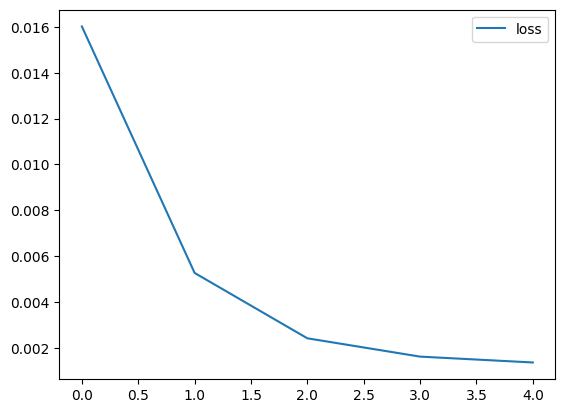

In [26]:
# Plot loss
sns.lineplot(rnn_model.history.history)

In [27]:
# Test
rnn_pred = rnn_model.predict(test_generator)

4356/4356 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step


In [28]:
# Buat dataframe test result, biar plotting dan eval gampang
test_result = pd.DataFrame({
    'Actual': test[LENGTH:, 0],
    'RNN_Prediction': rnn_pred.flatten()
})

<Axes: >

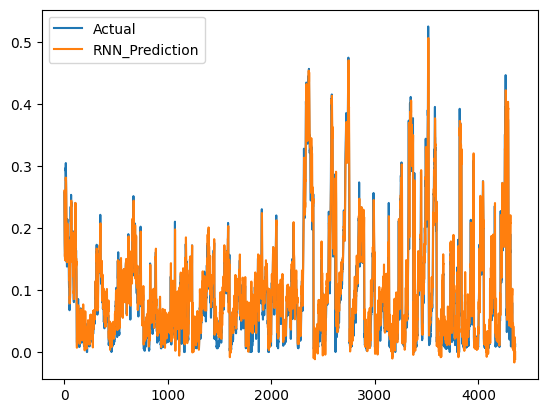

In [29]:
# Plot hasil forecast
test_result[['Actual', 'RNN_Prediction']].plot()

In [34]:
# Eval
mse_rnn = mse(test_result['Actual'], test_result['RNN_Prediction'])
mae_rnn = mae(test_result['Actual'], test_result['RNN_Prediction'])

eval = pd.DataFrame({
    'RNN': [mse_rnn, mae_rnn]
}, index=['MSE', 'MAE'])

eval

,RNN
MSE,0.000999
MAE,0.021454


# 2. LSTM

**Long Short Term Memory (LSTM)**

LSTM merupakan pengembangan dari RNN yang menyelesaikan permasalahan exploding / vanishing gradient. LSTM dapat menyimpan memori jangka panjang.


<img src = 'https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png'/>

<br>

LSTM menggunakan arsitektur **cell state**.
<img src = 'https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png' />

dan terdiri dari 3 gate, yaitu:
1. Forget gate: menentukan informasi yang dibuang dari cell state.
<img src = 'https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png' />

2. Input gate: menambahkan informasi baru ke cell state.
<img src = 'https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png' />
<img src = 'https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png' />

3. Output gate: melakukan perhitungan output.
<img src = 'https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png' />

[Referensi](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [35]:
# Buat model
lstm_model = Sequential([
    LSTM(20, return_sequences=True, input_shape=(LENGTH, n_features)),
    LSTM(20, return_sequences=True),
    LSTM(20),
    Dense(1),
])

# Summary
lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 20)         │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 20)         │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,821 (34.46 KB)

 Trainable params: 8,821 (34.46 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=1, restore_best_weights=True)

In [37]:
# Compile model
lstm_model.compile(optimizer="adam", loss="mse")

In [38]:
# Train model
EPOCHS = 5
lstm_model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping])


Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - loss: 0.0080 - val_loss: 0.0038
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - loss: 0.0028 - val_loss: 0.0017


<Axes: >

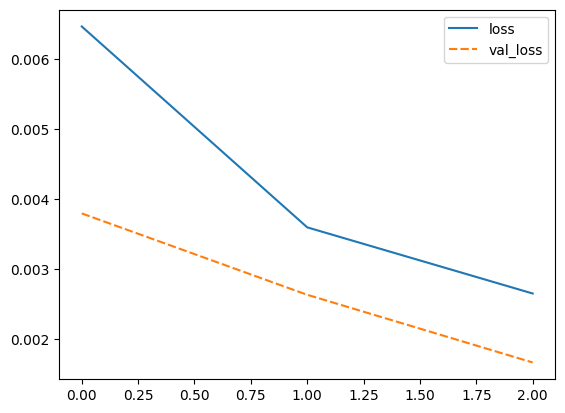

In [39]:
# Plot loss
sns.lineplot(lstm_model.history.history)

In [40]:
# Test
lstm_pred = lstm_model.predict(test_generator)

4356/4356 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step


In [41]:
# Buat dataframe test result, biar plotting dan eval gampang
test_result['LSTM_Prediction'] = lstm_pred

<Axes: >

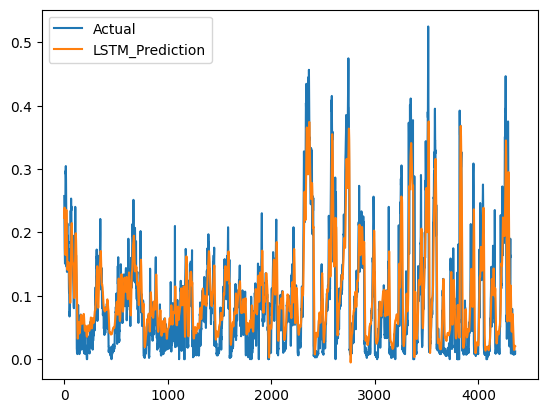

In [42]:
# Plot hasil forecast
test_result[['Actual', 'LSTM_Prediction']].plot()

In [43]:
# Eval
mse_lstm = mse(test_result['Actual'], test_result['LSTM_Prediction'])
mae_lstm = mae(test_result['Actual'], test_result['LSTM_Prediction'])
eval['LSTM'] = [mse_lstm, mae_lstm]
eval

,RNN,LSTM
MSE,0.000999,0.002637
MAE,0.021454,0.036054


# 3. GRU

**Gated Recurrent Unit**

GRU mirip dengan LSTM namun arsitekturnya lebih simpel. Pada GRU hanya ada hidden state dan tidak ada cell state.

<img src = 'https://miro.medium.com/v2/resize:fit:828/format:webp/1*jhi5uOm9PvZfmxvfaCektw.png'/>

GRU terdiri dari 2 gate, yaitu:
1. Reset gate: menentukan infromasi yang dibuang dari hidden state sebelumnya. (analog forget gate LSTM)
2. Update gate: memperbarui hidden gate dengan informasi baru (analog input gate LSTM)

[Referensi](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)


In [ ]:
# Buat model builder
def model_builder(hp):

  hp_units =

  model = Sequential([

  ])

  hp_learning_rate =

  model.compile( )

  return model

In [ ]:
# Buat tuner

!pip install keras_tuner




In [ ]:
# Hyper parameter search dan ambil hyperparameter terbaik



In [ ]:
# Buat model



In [ ]:
# Summary



In [ ]:
# Callback



In [ ]:
# Train model



In [ ]:
# Plot loss



In [ ]:
# Test



In [ ]:
# Buat dataframe test result, biar plotting dan eval gampang



In [ ]:
# Plot hasil forecast



In [ ]:
# Eval



mse_gru =
mae_gru =

eval['GRU'] =

eval